# Linking between data (AID) and algorithm (EDSR).
1) Linking to drive

2) Dataloader

3) Training the network

4) Evaluation (Saving material)

## Import and linking to drive

In [1]:
## Run once to link to google drive using GCP
#!sudo apt-get install google-drive-ocamlfuse
#!sudo add-apt-repository ppa:alessandro-strada/ppa
#!sudo apt-get update
#!sudo apt-get install google-drive-ocamlfuse

In [2]:
!google-drive-ocamlfuse -headless -id=553698332080-4ilebkr6tajj9d4on76a6sfjilo8dbob.apps.googleusercontent.com -secret=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

# Imports

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

import random

%matplotlib inline

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Resize, RandomVerticalFlip, RandomHorizontalFlip, Normalize
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

from pathlib import Path
import re

# Linking up drive and initialization

In [4]:
#Initializing google drive to a folder
if not os.path.exists("./acv"):
  os.makedirs("./acv")

!google-drive-ocamlfuse acv

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [5]:
os.chdir('/content/acv/Courses/COMS 4995-6 - Applied Computer Vision/Group Project/Codebase/AID')

# Data loader

In [6]:
#Define scale level
scale = 2

(600, 600)
torch.Size([3, 600, 600])
(600, 600, 3)


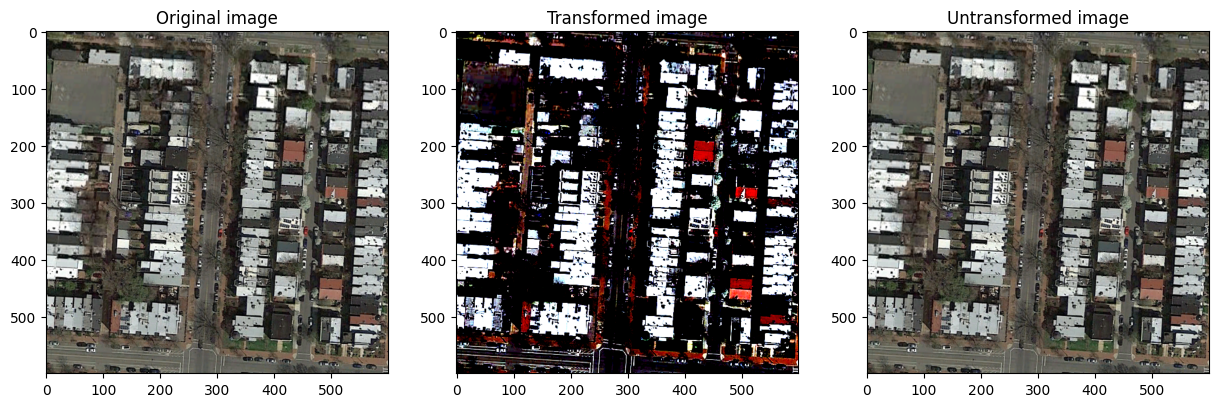

In [7]:
#Transform functions
data_unnormalize = transforms.Compose([
            transforms.Normalize(mean=[0, 0, 0], std=(1/0.2118,1/0.1872,1/0.1839,)),
            transforms.Normalize(mean=(-0.3911,-0.4033,-0.3585,), std=[1, 1, 1])
        ])

train_transforms = transforms.Compose([            
            transforms.ToTensor(),            # Convert the image to a tensor
            Normalize((0.3911,0.4033,0.3585,), (0.2118,0.1872,0.1839,)) 
        ])
flip_transform_vertical = transforms.Compose([
            RandomVerticalFlip(p=1)
        ])

flip_transform_horizontal = transforms.Compose([
            RandomHorizontalFlip(p=1)
        ])
      
test_transforms = transforms.Compose([            
            transforms.ToTensor(),            # Convert the image to a tensor 
            Normalize((0.3911,0.4033,0.3585,), (0.2118,0.1872,0.1839,))        
        ])

#Unit testing for normalize and unnormalize
img_sample = Image.open('../../Data/AID/AIDx1/DenseResidential/denseresidential_9.png').convert('RGB')
img_sample2 = train_transforms(img_sample)
img_sample3 = data_unnormalize(img_sample2).permute(1, 2, 0).numpy()

print(img_sample.size)
print(img_sample2.shape)
print(img_sample3.shape)

fig, axs = plt.subplots(1, 3, figsize=(15, 10))

# Display the LR and HR images using matplotlib
axs[0].imshow(img_sample)
axs[0].set_title('Original image')
axs[1].imshow(img_sample2.permute(1, 2, 0).numpy())
axs[1].set_title('Transformed image')
axs[2].imshow(img_sample3)
axs[2].set_title('Untransformed image')

plt.show()

In [8]:
class AIDSRDataset(Dataset):
    def __init__(self, dataLR_files, dataHR_files, upscale_factor):
        self.p = 0.5

        self.dataLR_files = np.genfromtxt(dataLR_files,dtype='str')
        self.dataHR_files = np.genfromtxt(dataHR_files,dtype='str')
        self.upscale_factor = upscale_factor
                  
    def __len__(self):
        return len(self.dataLR_files)
    
    def __getitem__(self, idx):
        # Load the image from disk 
        imgLR = Image.open(self.dataLR_files[idx]).convert('RGB') 
        imgHR = Image.open(self.dataHR_files[idx]).convert('RGB')
        
        # Apply the data transformations 
        img_lr = train_transforms(imgLR)
        img_hr = train_transforms(imgHR)

        if random.random() < 0.5:
            img_lr = flip_transform_vertical(img_lr)
            img_hr = flip_transform_vertical(img_hr)

        if random.random() < 0.5:
            img_lr = flip_transform_horizontal(img_lr)
            img_hr = flip_transform_horizontal(img_hr)
        
        return img_lr, img_hr

In [9]:
ls

AID-checkfiles.ipynb           check_mean.m
AID-DataPreprocessing.ipynb    samples/
AID-EDSR-04152023-1.ipynb      SRGAN-PyTorch-main/
AID-SRresnet-04152023-1.ipynb  SRGAN-TrainTestSplit.ipynb
AID-TrainTestSplit.ipynb


In [10]:
# Create an instance of the AIDSRDataset
train_dataset = AIDSRDataset(dataLR_files='../../Data/AID/Train1_5class/train_LRx' + str(scale) + '.csv',dataHR_files='../../Data/AID/Train1_5class/train_HR.csv', upscale_factor=scale)

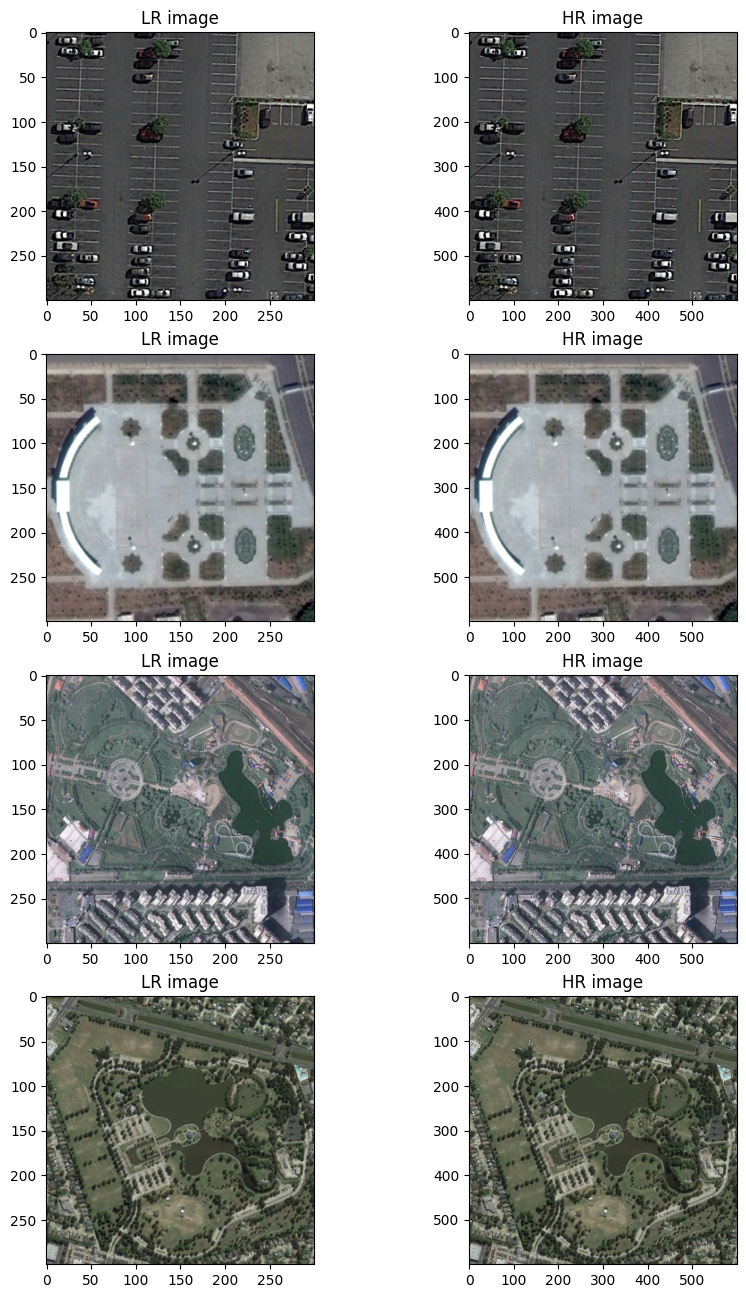

In [11]:
#Test to show data loader is working
batch_size = 4
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 1)

fig, axs = plt.subplots(batch_size, 2, figsize=(10, 4*batch_size))

for batch in dataloader:
  img_lr_batch, img_hr_batch = batch
  for i in range(len(img_lr_batch)): 
    img_lr = img_lr_batch[i]
    img_hr = img_hr_batch[i]
    
    if random.random() < 0.5:
        img_lr = flip_transform_vertical(img_lr)
        img_hr = flip_transform_vertical(img_hr)

    if random.random() < 0.5:
        img_lr = flip_transform_horizontal(img_lr)
        img_hr = flip_transform_horizontal(img_hr)

    img_LR = data_unnormalize(img_lr).permute(1, 2, 0).numpy()
    img_HR = data_unnormalize(img_hr).permute(1, 2, 0).numpy()
    
    # Display the LR and HR images using matplotlib
    axs[i,0].imshow(img_LR)
    axs[i,0].set_title('LR image')
    axs[i,1].imshow(img_HR)
    axs[i,1].set_title('HR image')
  break

plt.show()

# Running a sample training of EDSR

In [12]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [13]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  #device2 = torch.device('cuda:1')
else:
  device = torch.device('cpu')
print(device)
#print(device2)

cuda:0


In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, num_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1, bias=True)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out += residual
        return out

class EDSR(nn.Module):
    def __init__(self, num_channels=3, num_res_blocks=16, scale_factor=4):
        super(EDSR, self).__init__()
        self.conv_input = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=True)
        self.relu = nn.ReLU(inplace=True)
        self.res_blocks = nn.Sequential(*[ResidualBlock(64) for _ in range(num_res_blocks)])
        self.conv_mid = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=True)
        self.upscale = nn.Sequential(
            nn.Conv2d(64, num_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.Upsample(scale_factor=scale_factor, mode='bilinear')
        )

    def forward(self, x):
        out = self.conv_input(x)
        out = self.relu(out)
        residual = out
        out = self.res_blocks(out)
        out = self.conv_mid(out)
        out += residual
        out = self.upscale(out)
        return out

#Unit test
img_lr2 = img_lr.unsqueeze(0)  # add an extra dimension for batch size
model = EDSR(num_channels=3, num_res_blocks=16, scale_factor=scale)
output = model(img_lr2)
print(output.shape)

torch.Size([1, 3, 600, 600])


In [15]:
# Setting up parameters
num_epochs = 20
batch_size = 4
learning_rate = 1e-5
print_interval = 50
save_interval = 1

In [16]:
# Define the dataset and data loader
train_dataset = AIDSRDataset(dataLR_files='../../Data/AID/Train1_5class/train_LRx' + str(scale) + '.csv',dataHR_files='../../Data/AID/Train1_5class/train_HR.csv', upscale_factor=scale)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers = 1)

In [17]:
# Define model
model = EDSR(num_channels=3, num_res_blocks=16, scale_factor=scale).to(device)

## Create a DataParallel object (Failed, about the same speed)
#model = torch.nn.DataParallel(model_EDSR, device_ids=[device, device2])

# Define the loss function and optimizer
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
#Setup model history
model_outputs = '../../Data/AID/Outputs/EDSR1-Bicubic_X' + str(scale) + '_L1loss_lr1e4_041423/Model'
Path(model_outputs).mkdir(parents=True, exist_ok=True)

# load the saved state_dict (for an earlier epoch)
#saved_state_dict = torch.load(model_outputs + '/edsr_plus_epoch0.pth')
#model.load_state_dict(saved_state_dict) # load the saved state_dict into the model

In [20]:
# Train the model
model.train()

for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        # Move the inputs and targets to the device (CPU or GPU)
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print the loss every few batches
        if (i+1) % print_interval == 0:
            print("Epoch [{}/{}], Batch [{}/{}], Loss: {:.4f}".format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))
    
    # To add, evaluation every few epoches
    #Code to add soon

    # Save the trained model
    if (epoch+1) % save_interval == 0:
      torch.save(model.state_dict(), model_outputs + "/edsr_epoch" + str(epoch+1) + ".pth")

Epoch [1/20], Batch [50/332], Loss: 0.2084
Epoch [1/20], Batch [100/332], Loss: 0.1639
Epoch [1/20], Batch [150/332], Loss: 0.1604
Epoch [1/20], Batch [200/332], Loss: 0.1423
Epoch [1/20], Batch [250/332], Loss: 0.1058
Epoch [1/20], Batch [300/332], Loss: 0.1282
Epoch [2/20], Batch [50/332], Loss: 0.1180
Epoch [2/20], Batch [100/332], Loss: 0.1519
Epoch [2/20], Batch [150/332], Loss: 0.1977
Epoch [2/20], Batch [200/332], Loss: 0.1399
Epoch [2/20], Batch [250/332], Loss: 0.0986
Epoch [2/20], Batch [300/332], Loss: 0.1098
Epoch [3/20], Batch [50/332], Loss: 0.1294
Epoch [3/20], Batch [100/332], Loss: 0.1176
Epoch [3/20], Batch [150/332], Loss: 0.1676
Epoch [3/20], Batch [200/332], Loss: 0.1083
Epoch [3/20], Batch [250/332], Loss: 0.0799
Epoch [3/20], Batch [300/332], Loss: 0.1105
Epoch [4/20], Batch [50/332], Loss: 0.1003
Epoch [4/20], Batch [100/332], Loss: 0.0867
Epoch [4/20], Batch [150/332], Loss: 0.1027
Epoch [4/20], Batch [200/332], Loss: 0.1210
Epoch [4/20], Batch [250/332], Loss:

Path(model_outputs).mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), model_outputs + "/edsr_plus_epoch" + str(epoch) + ".pth")

## Evaluation Script

In [21]:
test_dataset = AIDSRDataset(dataLR_files='../../Data/AID/Test1_2class/test_LRx' + str(scale) + '.csv',dataHR_files='../../Data/AID/Test1_2class/test_HR.csv', upscale_factor=scale)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True, num_workers = 1)

In [22]:
#Running sample test image
model.eval()
test_lr, test_hr = next(iter(test_loader))
output = model(test_lr.to(device))

#Compare LR and HR
fig, axs = plt.subplots(1, 3, figsize=(25, 20))
    
img_LR = data_unnormalize(test_lr).permute(2, 3, 1, 0).squeeze(3).numpy()
img_out = data_unnormalize(output).permute(2, 3, 1, 0).squeeze(3).detach().cpu().numpy()
img_HR = data_unnormalize(test_hr).permute(2, 3, 1, 0).squeeze(3).numpy()

# Display the LR and HR images using matplotlib
axs[0].imshow(img_LR)
axs[0].set_title('LR image')
axs[1].imshow(img_out)
axs[1].set_title('HR image')
axs[2].imshow(img_HR)
axs[2].set_title('HR image')

plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [23]:
##Validation data
#Create folders for output
dir_out = '../../Data/AID/Outputs/EDSR1-Bicubic_X' + str(scale) + '_L1loss_lr1e4_041423/Images_Valid/'
Path(dir_out).mkdir(parents=True, exist_ok=True)

#Extracting test data locations 
list_files = np.genfromtxt("../../Data/AID/Train1_5class/valid_LRx" + str(scale) + '.csv',dtype='str')

#Processing test data
model.eval()

for file in list_files:
    if file == '.':
      continue

    imgLR = Image.open(file).convert('RGB')  

    # Apply the data transformations
    img_lr = train_transforms(imgLR)
    
    output = model(img_lr.unsqueeze(0).to(device))
    img_out = data_unnormalize(output).permute(2, 3, 1, 0).squeeze(3).detach().cpu().numpy() 
    
    # Save the output image
    ind = [m.start() for m in list(re.finditer(r'/',file))]

    im = Image.fromarray(np.uint8(img_out*255))
    im.save(dir_out + file[ind[-1]+1:])

    #plt.imshow((img_out*255).astype(np.uint8))
    #plt.imshow(img_out)
     
#plt.show()


IsADirectoryError: ignored

In [32]:
##Testing data
#Create folders for output
dir_out = '../../Data/AID/Outputs/EDSR1-Bicubic_X' + str(scale) + '_L1loss_lr1e4_041423/Images_Test/'
Path(dir_out).mkdir(parents=True, exist_ok=True)

#Extracting test data locations 
list_files = np.genfromtxt("../../Data/AID/Test1_2class/test_LRx" + str(scale) + '.csv',dtype='str')

#Processing test data
model.eval()

for file in list_files:
    if file == '.':
      continue

    imgLR = Image.open(file).convert('RGB')  
    
    # Apply the data transformations
    img_lr = train_transforms(imgLR)
    
    output = model(img_lr.unsqueeze(0).to(device))
    img_out = data_unnormalize(output).permute(2, 3, 1, 0).squeeze(3).detach().cpu().numpy() 
    
    # Save the output image
    ind = [m.start() for m in list(re.finditer(r'/',file))]

    im = Image.fromarray(np.uint8(img_out*255))
    im.save(dir_out + file[ind[-1]+1:])

    #plt.imshow((img_out*255).astype(np.uint8))
    #plt.imshow(img_out)
     
#plt.show()


OSError: ignored

In [ ]:
# Confirming file is saved properly (denseresidential_109.png)   
filename = '../../Data/AID/Outputs/EDSR1-Bicubic_X' + str(scale) + '_L1loss_lr1e4_041423/Images_Test/denseresidential_109.png'
filename2 = '../../Data/AID/AIDx1/DenseResidential/denseresidential_109.png'
filename3 = '../../Data/AID/AIDx' + str(scale) + '/DenseResidential/denseresidential_109.png'
imgSR = Image.open(filename).convert('RGB')  
imgHR = Image.open(filename2).convert('RGB')  
imgLR = Image.open(filename3).convert('RGB')

img_lr = train_transforms(imgLR)
output = model(img_lr.unsqueeze(0).to(device))
img_out = data_unnormalize(output).permute(2, 3, 1, 0).squeeze(3).detach().cpu().numpy() 

#Compare LR and HR
fig, axs = plt.subplots(1, 3, figsize=(25, 20)) 

# Display the LR and HR images using matplotlib
axs[0].imshow(imgSR)
axs[0].set_title('SR image')
axs[1].imshow(imgHR)
axs[1].set_title('HR image')
axs[2].imshow(imgLR)
axs[2].set_title('LR image')

plt.show()

#Try saving and loading again for verification

In [ ]:
#Convert to Pillow
from PIL import Image
from matplotlib import cm

#Save with Pillow
im = Image.fromarray(np.uint8(img_out*255))
im.save('testPIL.png')

im_pil = Image.open('testPIL.png').convert('RGB')  

#Save with cv2
cv2.imwrite('testcv2.png', img_out*255)
im_cv2 = cv2.imread('testcv2.png')

im_cv2pil =Image.open('testcv2.png').convert('RGB')

#Compare LR and HR
fig, axs = plt.subplots(1, 5, figsize=(25, 20)) 

# Display the LR and HR images using matplotlib
axs[0].imshow(im_cv2)
axs[0].set_title('SR image (Saved and Reloaded with cv2)')
axs[1].imshow(im)
axs[1].set_title('SR image2(Testing)')
axs[2].imshow(img_out)
axs[2].set_title('SR image2')
axs[3].imshow(im_pil)
axs[3].set_title('SR image2(Saved and Reloaded from Pil')
axs[4].imshow(im_cv2pil)
axs[4].set_title('SR image2(Saved w/ cv2 and Reloaded from Pil')

plt.show()